<a href="https://colab.research.google.com/github/Tobias-Rom3ro/Pipeline-DirtyIris/blob/main/Random_Forest_vs_Red_Neuronal_(Breast_Cancer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧑‍💻Taller de Laboratorios: Comparación de Modelos de ML (Random Forest vs Red Neuronal con Dataset Breast Cancer)
## Autores: Jenifer Roa y Tobías Romero.

---



## 1. Importación de librerías.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Configuración de plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Carga de datos.

In [ ]:
# Cargar dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Crear DataFrame para mejor manipulación
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

## 3. Análisis exploratorio  de datos.

In [ ]:
print("=== INFORMACIÓN BÁSICA DEL DATASET ===")
print(f"Forma del dataset: {df.shape}")
print(f"Número de características: {X.shape[1]}")
print(f"Clases: {data.target_names}")
print(f"Nombres de características (primeras 10): {list(data.feature_names[:10])}")

print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df.describe())

print("\n=== INFORMACIÓN DE VALORES NULOS ===")
print(df.isnull().sum().sum(), "valores nulos en total")

print("\n=== DISTRIBUCIÓN DE CLASES ===")
class_distribution = df['target'].value_counts()
print(class_distribution)
print(f"\nPorcentajes:")
for i, (class_val, count) in enumerate(class_distribution.items()):
    class_name = data.target_names[class_val]
    percentage = (count / len(df)) * 100
    print(f"{class_name}: {count} casos ({percentage:.1f}%)")

=== INFORMACIÓN BÁSICA DEL DATASET ===
Forma del dataset: (569, 31)
Número de características: 30
Clases: ['malignant' 'benign']
Nombres de características (primeras 10): [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension')]

=== ESTADÍSTICAS DESCRIPTIVAS ===
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000  

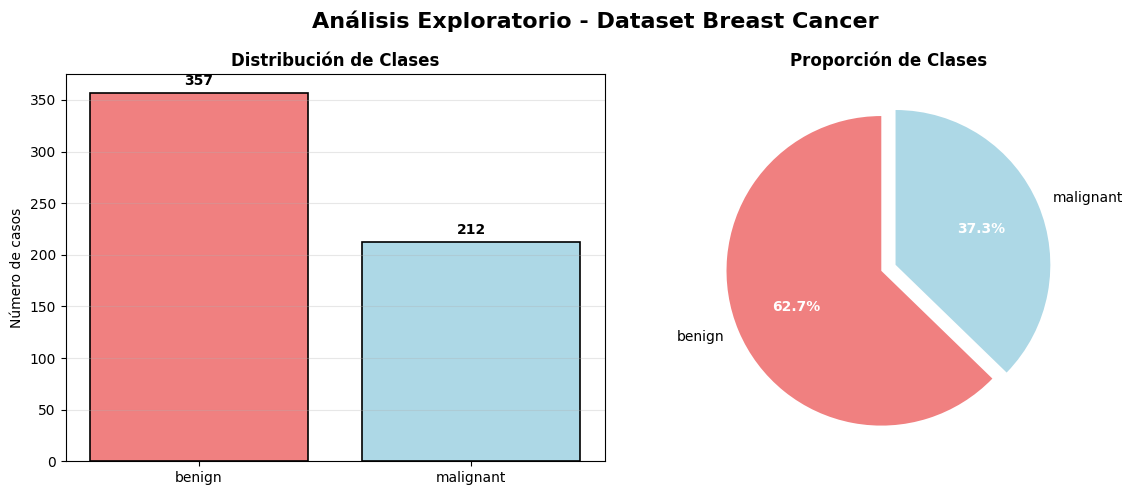

In [ ]:
# Configurar subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Análisis Exploratorio - Dataset Breast Cancer', fontsize=16, fontweight='bold')

# 4.1 Gráfico de barras - Distribución de clases
ax1 = axes[0]
class_names = [data.target_names[i] for i in class_distribution.index]
bars = ax1.bar(class_names, class_distribution.values,
               color=['lightcoral', 'lightblue'], edgecolor='black', linewidth=1.2)
ax1.set_title('Distribución de Clases', fontweight='bold')
ax1.set_ylabel('Número de casos')
ax1.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bar, value in zip(bars, class_distribution.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{value}', ha='center', va='bottom', fontweight='bold')

# 4.2 Gráfico circular - Porcentaje de clases
ax2 = axes[1]
colors = ['lightcoral', 'lightblue']
wedges, texts, autotexts = ax2.pie(class_distribution.values,
                                   labels=class_names,
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90,
                                   explode=(0.05, 0.05))
ax2.set_title('Proporción de Clases', fontweight='bold')

# Mejorar formato del pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

## 4. Preparación de datos.

In [ ]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"Tamaño conjunto prueba: {X_test.shape}")
print(f"Distribución train - Malignos: {np.sum(y_train == 0)}, Benignos: {np.sum(y_train == 1)}")
print(f"Distribución test - Malignos: {np.sum(y_test == 0)}, Benignos: {np.sum(y_test == 1)}")

Tamaño conjunto entrenamiento: (455, 30)
Tamaño conjunto prueba: (114, 30)
Distribución train - Malignos: 170, Benignos: 285
Distribución test - Malignos: 42, Benignos: 72


## 5. Entrenamiento y evaluación individual de modelos.

### 5.1. Modelo A: Random Forest Classifier

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("Entrenando Random Forest...")
rf_model.fit(X_train, y_train)

# Predicciones
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

Entrenando Random Forest...



=== MÉTRICAS RANDOM FOREST ===
Exactitud (Accuracy): 0.9561
Precisión: 0.9589
Recall: 0.9722
F1-Score: 0.9655
AUC-ROC: 0.9934


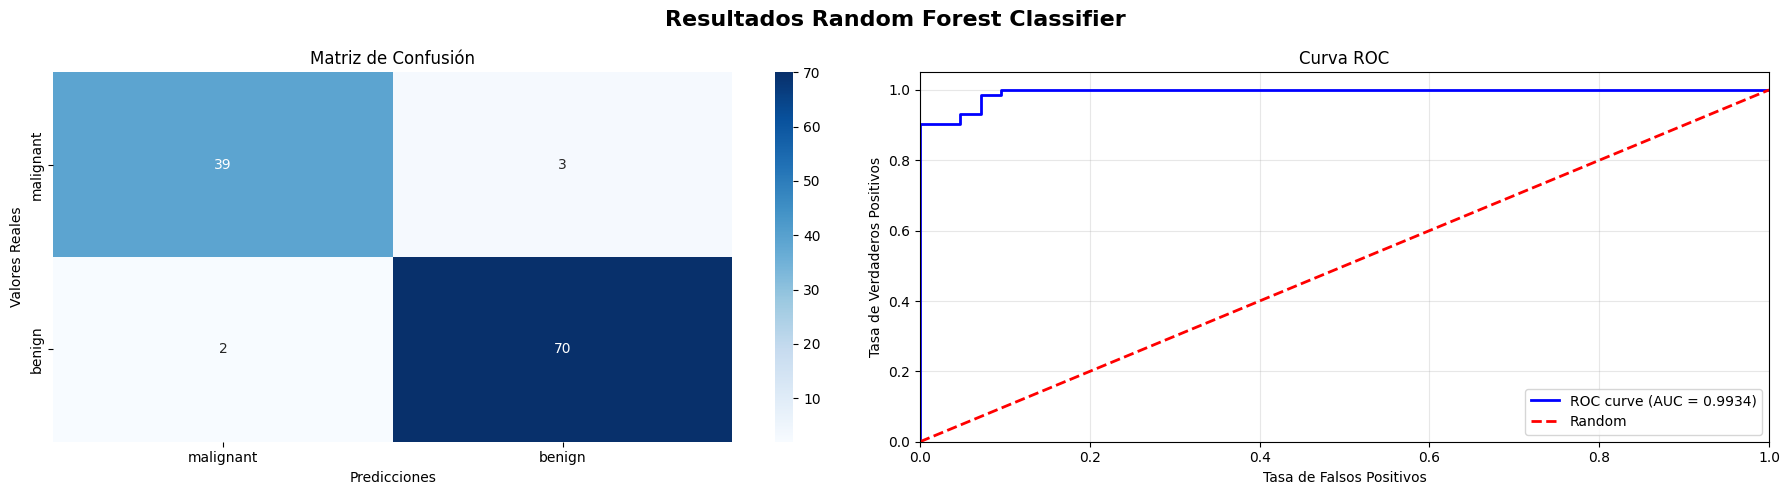

In [ ]:
# Métricas
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print("\n=== MÉTRICAS RANDOM FOREST ===")
print(f"Exactitud (Accuracy): {rf_accuracy:.4f}")
print(f"Precisión: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"AUC-ROC: {rf_auc:.4f}")

# Visualización de resultados Random Forest
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Resultados Random Forest Classifier', fontsize=16, fontweight='bold')

# Matriz de confusión
rf_cm = confusion_matrix(y_test, rf_pred)
ax1 = axes[0]
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=data.target_names, yticklabels=data.target_names)
ax1.set_title('Matriz de Confusión')
ax1.set_ylabel('Valores Reales')
ax1.set_xlabel('Predicciones')

# Curva ROC
ax2 = axes[1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
ax2.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC curve (AUC = {rf_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Tasa de Falsos Positivos')
ax2.set_ylabel('Tasa de Verdaderos Positivos')
ax2.set_title('Curva ROC')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

El Random Forest demuestra un rendimiento excepcional con una exactitud del 95.61% (109/114 casos correctos), precisión del 95.89% y recall del 97.22%, logrando un AUC-ROC de 0.9934 que indica capacidad casi perfecta de discriminación entre tumores malignos y benignos. La matriz de confusión revela solo 5 errores: 3 falsos positivos (tumores benignos clasificados como malignos) y 2 falsos negativos más críticos (tumores malignos no detectados), representando tasas de error muy bajas del 7.1% y 2.8% respectivamente.

### 5.2. Modelo B: Red Neuronal Densa (MLP)

In [ ]:
# Estandarización de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos estandarizados correctamente.")

# Construcción del modelo
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilación del modelo
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

print("\n=== ARQUITECTURA DEL MODELO ===")
mlp_model.summary()

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento
print("\nEntrenando Red Neuronal...")
history = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Predicciones
mlp_pred_proba = mlp_model.predict(X_test_scaled).flatten()
mlp_pred = (mlp_pred_proba > 0.5).astype(int)

Datos estandarizados correctamente.

=== ARQUITECTURA DEL MODELO ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando Red Neuronal...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - AUC: 0.5486 - accuracy: 0.4738 - loss: 0.7403 - val_AUC: 0.9739 - val_accuracy: 0.9231 - val_loss: 0.4695
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9534 - accuracy: 0.9151 - loss: 0.4547 - val_AUC: 0.9849 - val_accuracy: 0.9231 - val_loss: 0.3184
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9785 - accuracy: 0.9247 - loss: 0.3054 - val_AUC: 0.9856 - val_accuracy: 0.9231 - val_loss: 0.2234
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9858 - accuracy: 0.9634 - loss: 0.2036 - val_AUC: 0.9886 - val_accuracy: 0.9560 - val_loss: 0.1684
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9865 - accuracy: 0.9459 - loss: 0.1678 - val_AUC: 0.9916 - val_accuracy: 0.9560 - val_loss: 0.1360
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9877 - accuracy: 0.9584 - loss: 0.1400 - val_AUC: 0.9930 - val_accuracy: 0.9560 - val_loss: 0.1162
Epoch 7/100
12


=== MÉTRICAS RED NEURONAL ===
Exactitud (Accuracy): 0.9649
Precisión: 0.9857
Recall: 0.9583
F1-Score: 0.9718
AUC-ROC: 0.9924


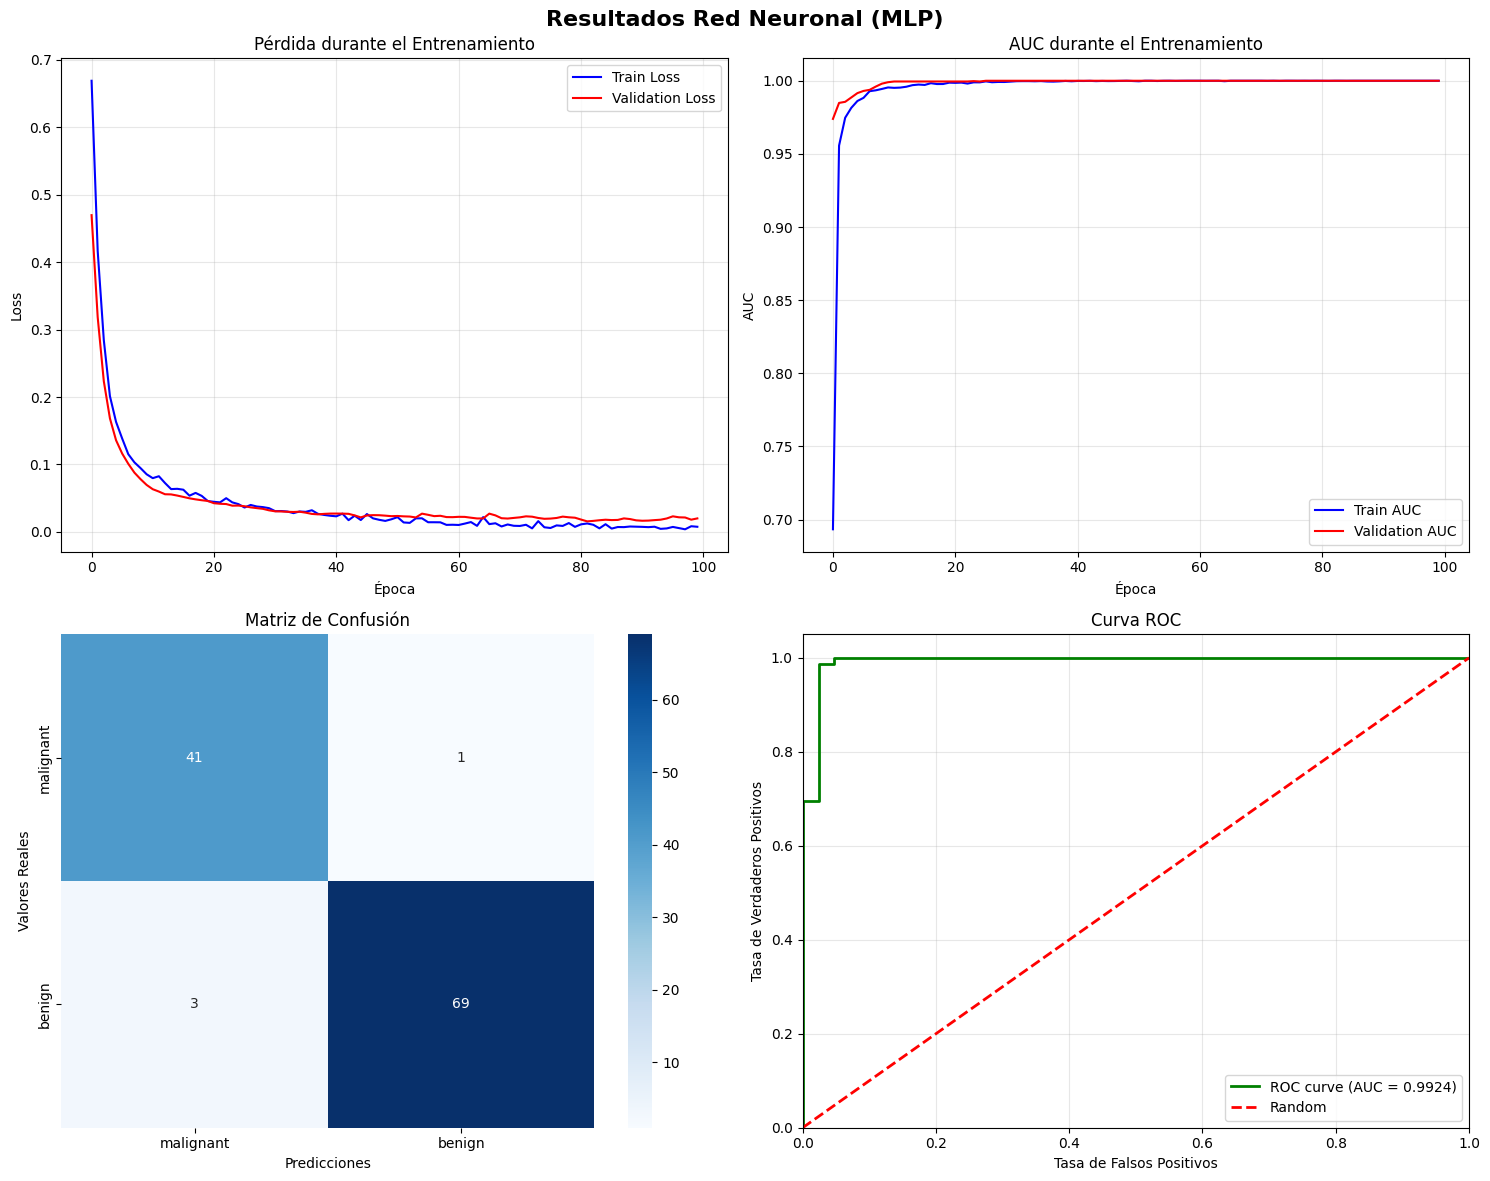

In [ ]:
# Métricas
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)
mlp_f1 = f1_score(y_test, mlp_pred)
mlp_auc = roc_auc_score(y_test, mlp_pred_proba)

print("\n=== MÉTRICAS RED NEURONAL ===")
print(f"Exactitud (Accuracy): {mlp_accuracy:.4f}")
print(f"Precisión: {mlp_precision:.4f}")
print(f"Recall: {mlp_recall:.4f}")
print(f"F1-Score: {mlp_f1:.4f}")
print(f"AUC-ROC: {mlp_auc:.4f}")

# Visualización de resultados Red Neuronal
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Resultados Red Neuronal (MLP)', fontsize=16, fontweight='bold')

# Historia del entrenamiento - Loss
ax1 = axes[0, 0]
ax1.plot(history.history['loss'], label='Train Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax1.set_title('Pérdida durante el Entrenamiento')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Historia del entrenamiento - AUC
ax2 = axes[0, 1]
ax2.plot(history.history['AUC'], label='Train AUC', color='blue') # Changed 'auc' to 'AUC'
ax2.plot(history.history['val_AUC'], label='Validation AUC', color='red') # Changed 'val_auc' to 'val_AUC'
ax2.set_title('AUC durante el Entrenamiento')
ax2.set_xlabel('Época')
ax2.set_ylabel('AUC')
ax2.legend()
ax2.grid(alpha=0.3)

# Matriz de confusión
mlp_cm = confusion_matrix(y_test, mlp_pred)
ax3 = axes[1, 0]
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=data.target_names, yticklabels=data.target_names)
ax3.set_title('Matriz de Confusión')
ax3.set_ylabel('Valores Reales')
ax3.set_xlabel('Predicciones')

# Curva ROC
ax4 = axes[1, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_pred_proba)
ax4.plot(fpr_mlp, tpr_mlp, color='green', lw=2, label=f'ROC curve (AUC = {mlp_auc:.4f})')
ax4.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('Tasa de Falsos Positivos')
ax4.set_ylabel('Tasa de Verdaderos Positivos')
ax4.set_title('Curva ROC')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

La red neuronal (MLP) alcanza un rendimiento excelente con una exactitud del 96.49% (110/114 casos correctos), precisión del 98.57% y recall del 95.83%, obteniendo un AUC-ROC de 0.9924 que demuestra capacidad casi perfecta de discriminación. Las curvas de entrenamiento muestran un aprendizaje óptimo donde tanto la pérdida como el AUC convergen rápidamente sin signos de overfitting, con el early stopping activándose apropiadamente para preservar el mejor modelo basado en AUC de validación. La matriz de confusión revela solo 4 errores totales: 1 falso positivo (tumor benigno clasificado como maligno) y 3 falsos negativos (tumores malignos no detectados), con tasas de error del 2.4% y 4.2% respectivamente.

## 6. Comparación final de modelos.

     Métrica  Random Forest  Red Neuronal
0   Accuracy         0.9561        0.9649
1  Precision         0.9589        0.9857
2     Recall         0.9722        0.9583
3   F1-Score         0.9655        0.9718
4    AUC-ROC         0.9934        0.9924


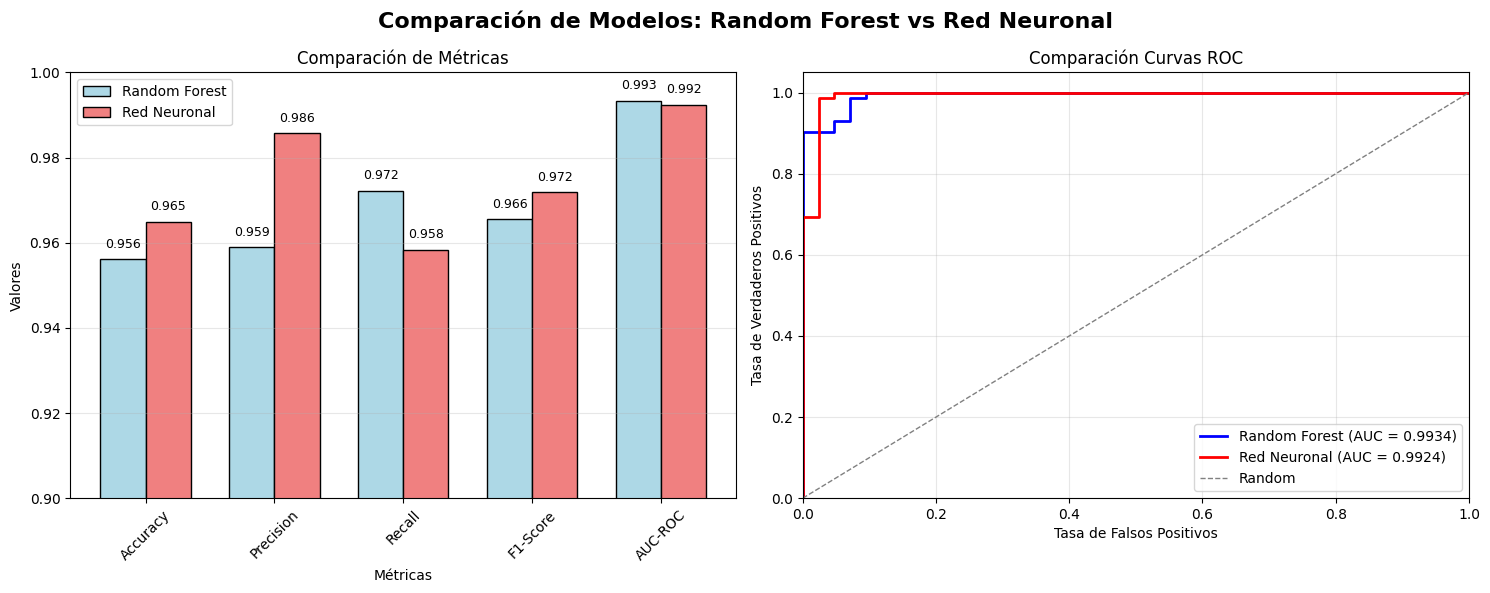

In [ ]:
# Crear DataFrame de comparación
comparison_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Random Forest': [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc],
    'Red Neuronal': [mlp_accuracy, mlp_precision, mlp_recall, mlp_f1, mlp_auc]
})

print(comparison_df.round(4))

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Comparación de Modelos: Random Forest vs Red Neuronal', fontsize=16, fontweight='bold')

# Gráfico de barras comparativo
ax1 = axes[0]
x = np.arange(len(comparison_df['Métrica']))
width = 0.35

bars1 = ax1.bar(x - width/2, comparison_df['Random Forest'], width,
                label='Random Forest', color='lightblue', edgecolor='black')
bars2 = ax1.bar(x + width/2, comparison_df['Red Neuronal'], width,
                label='Red Neuronal', color='lightcoral', edgecolor='black')

ax1.set_xlabel('Métricas')
ax1.set_ylabel('Valores')
ax1.set_title('Comparación de Métricas')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Métrica'], rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.9, 1.0])  # Zoom para mejor visualización

# Añadir valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Curvas ROC comparativas
ax2 = axes[1]
ax2.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {rf_auc:.4f})')
ax2.plot(fpr_mlp, tpr_mlp, color='red', lw=2, label=f'Red Neuronal (AUC = {mlp_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Tasa de Falsos Positivos')
ax2.set_ylabel('Tasa de Verdaderos Positivos')
ax2.set_title('Comparación Curvas ROC')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


En conclusión, ambos modelos tienen diferencias mínimas en todas las métricas: la Red Neuronal supera ligeramente en exactitud (96.49% vs 95.61%) y precisión (98.57% vs 95.89%), mientras que Random Forest tiene ventaja en recall (97.22% vs 95.83%), resultando en F1-scores muy similares (96.55% vs 97.18%) y AUC-ROC casi idénticos (99.34% vs 99.24%). Las curvas ROC superpuestas confirman capacidades de discriminación prácticamente iguales, con ambas curvas muy próximas al punto ideal (0,1). En términos prácticos, Random Forest ofrece mayor interpretabilidad mediante importancia de variables y requiere menos preprocesamiento, mientras que la Red Neuronal necesita estandarización pero puede capturar relaciones no lineales más complejas;



---


# 2da parte: Laboratorios Realizados.

## Laboratorios de Google Cloud.
<img src='https://drive.google.com/uc?id=1U1xNRgGEO3ulhH7UsJSXI4Ecoo7QizcR'>
<img src='https://drive.google.com/uc?id=14usY1D7F0YCKWGL3evyArb7wm_ELkGZ2'>

## Laboratorio de Labex.io
<img src='https://drive.google.com/uc?id=1plQ_xTZeQe-9kB8HlPTmUQsGa8IHAxCP'>
<img src='https://drive.google.com/uc?id=1jS_RWgRxr1BFbGVfKYVUsBFcKIlqupFc'>
<img src='https://drive.google.com/uc?id=1tH71ROTWCdSxSwMXslE9plQUVSD2I8p1'>
<img src='https://drive.google.com/uc?id=13Ay2R6Jnq6RiFHI_IGtl7Koipt9Npi4I'>
<img src='https://drive.google.com/uc?id=1xUL86ZmnC3AoVWBQpn2mavGKzEyXWPmy'>